https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

In [20]:
# import libs and config stuff
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


## Torchvision
import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import layers


!pip install -U tensorflow-addons
     

import tensorflow_addons as tfa


<ipython-input-20-3bc222d10891>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 640x480 with 0 Axes>

In [21]:
from pathlib import Path
import os 

batch_size = 1
img_size = 72

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((img_size,img_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img
    

train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = train_datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [27]:
def create_model(optimizer='rmsprop', fine_tune=0):

    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(img_size, img_size),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    data_augmentation.layers[0].adapt(x_train)
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.trainable = False
    prediction_layer = Dense(n_classes, activation='softmax')

    model = Sequential()
    model.add(data_augmentation)
    model.add(vgg)
    model.add(Flatten(name="flatten"))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1072, activation='relu'))
    model.add(Dropout(0.2))
    model.add(prediction_layer)
    
    return model

In [23]:
input_shape = (72, 72, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=7

n_epochs = 100
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 50


In [24]:
x_train = []
y_train = []
x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(valid_generator)

for i in range(len(train_generator)-1):
    x_train = np.append(x_train, train_generator[i+1][0], axis=0)
    y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(valid_generator)-1):
    x_test = np.append(x_test, valid_generator[i+1][0], axis=0)
    y_test = np.append(y_test, valid_generator[i+1][1], axis=0)

In [25]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_train = y_train.reshape((280,1))
y_test = y_test.astype(int)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (280, 72, 72, 3) - y_train shape: (280,)
x_test shape: (35, 72, 72, 3) - y_test shape: (35,)
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)


In [28]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=1,#batch_size,
        epochs=50,#num_epochs,
        validation_data=(x_test,y_test),
        callbacks=[checkpoint_callback],
    )
    return history


vgg_classifier = create_model()
history = run_experiment(vgg_classifier)

Epoch 1/50
280/280 [==============================] - 56s 195ms/step - loss: 1.4252 - accuracy: 0.6393 - top-5-accuracy: 0.9357 - val_loss: 0.3986 - val_accuracy: 0.8286 - val_top-5-accuracy: 1.0000
Epoch 2/50
280/280 [==============================] - 50s 179ms/step - loss: 0.5821 - accuracy: 0.8464 - top-5-accuracy: 1.0000 - val_loss: 0.5569 - val_accuracy: 0.9143 - val_top-5-accuracy: 1.0000
Epoch 3/50
280/280 [==============================] - 49s 176ms/step - loss: 0.4866 - accuracy: 0.8821 - top-5-accuracy: 1.0000 - val_loss: 0.5693 - val_accuracy: 0.9143 - val_top-5-accuracy: 1.0000
Epoch 4/50
280/280 [==============================] - 49s 176ms/step - loss: 0.3668 - accuracy: 0.9071 - top-5-accuracy: 1.0000 - val_loss: 0.4205 - val_accuracy: 0.8571 - val_top-5-accuracy: 1.0000
Epoch 5/50
280/280 [==============================] - 51s 182ms/step - loss: 0.1399 - accuracy: 0.9607 - top-5-accuracy: 1.0000 - val_loss: 0.8927 - val_accuracy: 0.8857 - val_top-5-accuracy: 0.9714
Epoch

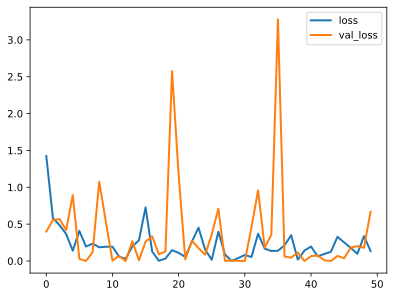

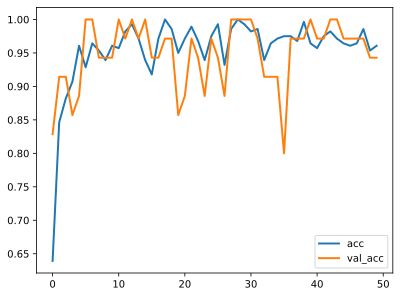

In [29]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [31]:
vgg_classifier.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 72, 72, 3)        7         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_10 (Dropout)        (None, 4096)              0         
                                                                 
 dense_17 (Dense)            (None, 1072)              4391984   
                                                      

In [30]:
probabilities = vgg_classifier.predict(x_test)

y_predicted = np.argmax(probabilities, axis=1)

correct = 0

for i in range(len(y_predicted)):
  if y_predicted[i] == y_test[i]:
    correct+=1

accuracy = correct/len(y_predicted)

accuracy *= 100

print("accuracy [%]: ", round(accuracy,2))
     


2/2 [==============================] - 6s 282ms/step
accuracy [%]:  94.29
